## Bias-variance analysis 

We perform an anaysis of the bias-variance radeoff on a regression problem. 
The goal is to study the bias-variance tradeoff for three sets of algorithms for a data set as a function of the complexity of the model. 

We begin by studying linear regression using Ordinary Least Squares (OLS), Ridge regression and Lasso regression. Next, we study deep learning using a Feed Forward Neural Network (FFNN), and finally we study some ensamble methods. 

Methods: 

    - Linear Regression (OLS, Ridge, Lasso)

    - Deep learning (FFNN and/or recurrent neural networks)
    
    - Ensemble methods (Decision trees, bagging, random forests and boosting)

The bias measures how well the model captures the mapping function between inputs and outputs. In other words, it captures the strength of the assumption the model has about the functional form of the mapping between the input and output, which reflects how accurate the functional form of the model is compared to the true relationshp between predictors and the outcome. 

— Page 97, Applied Predictive Modeling, 2013.

A model with high bias makes strong assumptions regarding the functional form of the mapping of inputs to outputs, but it is not useful when the functional form for th eproblem does not match the assumptions of the model. When the bias is weak, we have weak assumptions regarding the functional form of the mapping of inputs to outputs. 


The variance of a model is the amount the performance of the model changes wen it is fit for different training dta. This captures the impact of the specifics the data has on the model. 
Essentially, the variance tells us by how much the model changes if we estimate it using a different training data set. 

— Page 34, An Introduction to Statistical Learning with Applications in R, 2014.

A model with high variance will change a lot with small changes to the training dataset. Conversely, a model with low variance will change little with small or even large changes to the training dataset.

    Low Variance: Small changes to the model with changes to the training dataset.
    High Variance: Large changes to the model with changes to the training dataset.




A good model has a balanced relationship between the bias and variance. Ideally, we would like a model with both low bias and variance. However, this is challenging, as reducing bias can be done by increasing variance, and reducing the variance can be done by increasing the bias. This is what we referr to as a trade-off, as it is simple to obtain a method with low bis and high variance, or a method with low variance but high bias, 

— Page 36, An Introduction to Statistical Learning with Applications in R, 2014.

but obtaining both is more difficult. 

The bias-variance tradeoff gives us a framework for how we choose models and model configuration, which is what we study here. 





High bias is not always bad, nor is high variance, but they can lead to poor results.

We often must test a suite of different models and model configurations in order to discover what works best for a given dataset. A model with a large bias may be too rigid and underfit the problem. Conversely, a large variance may overfit the problem.

We may decide to increase the bias or the variance as long as it decreases the overall estimate of model error.


https://towardsdatascience.com/ridge-regression-for-better-usage-2f19b3a202db





When we have obtained ˆβ, we need an estimate of how
good our approximation is. For this we use the bias-
variance trade-off in the context of continuous predictions
such as regression.

 This variance term
measures the deviation from the true data and the mean
value of the model, called the bias term, and finally the
variance of the noise

nserting into the cost function for the model yields:
E[(y −  ̃y)2] = (f −  ̃y)2 + E[ ̃y − E[ ̃y]] + σ2
= (Bias[ ̃y])2 + Var[  ̃f ] + σ2, (10)
with
(Bias[ ̃y])2 = (y − E[ ̃y])2, (11)
and
Var[  ̃f ] = 1
n
X
i
( ̃yi − E[ ̃y])2. (12)
A model having a high bias means that it predicts inaccu-
rate results, even if we only see a small variance in these
predictions. Having a lower bias, but with higher vari-
ance, implies that out predictions are centered around
the true value, but vary markedly. When predicting the
model we want to ensure the optimal bias-variance trade-
off, in order to get the most trustworthy results

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("seaborn-darkgrid")

from sklearn.model_selection import train_test_split
from mlxtend.evaluate        import bias_variance_decomp
from sklearn.utils           import resample
from sklearn.linear_model    import LinearRegression, Ridge, Lasso
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.neural_network  import MLPRegressor
from sklearn.ensemble        import BaggingClassifier, RandomForestRegressor, GradientBoostingRegressor

from tqdm import tqdm, trange
from random import random, seed
np.random.seed(2019) #set seed for troubleshooting (same random outputs every run)

The bias-variance is tested on a data set generated from the Franke function. 

In [9]:
def FrankeFunction(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# From lecture notes on Ridge/Lasso regression (4.8)
def create_X(x, y, n): 
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

# Making meshgrid of random datapoints and computing Franke's function
N = 40
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

x_, y_ = np.meshgrid(x,y)

sigma = 0.1 # Variance of noise 
noise = np.random.normal(0, sigma, len(x_)*len(x_)) 
noise = noise.reshape(len(x_), len(x_))

z = FrankeFunction(x_, y_) + noise #Franke with added noise

## Linear Regression (OLS, Ridge, Lasso)

In [12]:
n = 13
n_boostraps = 100
maxdegree = n

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)

def biasvar_linreg(solver): 
    for degree in range(maxdegree):
        X_ = create_X(x_, y_, degree+1)
        X_train_, X_test_, z_train_, z_test_ = train_test_split(X_, z.ravel(), test_size=0.2, random_state = 40)
        z_pred = np.empty((z_test_.shape[0], n_boostraps))
        for i in range(n_boostraps):
            X_, z_ = resample(X_train_, z_train_)
            if solver == 'ols': 
                model = LinearRegression()
            elif solver == 'ridge': 
                model = Ridge(alpha=0.5) 
            elif solver == 'lasso': 
                model = Lasso(alpha=0.01) 
            
            z_pred[:, i] = model.fit(X_, z_).predict(X_test_).ravel() 

        error[degree] = np.mean( np.mean((z_test_.reshape(-1, 1) - z_pred)**2, axis=1, keepdims=True) )
        bias[degree] = np.mean( (z_test_.reshape(-1, 1) - np.mean(z_pred, axis=1, keepdims=True))**2 )
        variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

    return error, bias, variance 

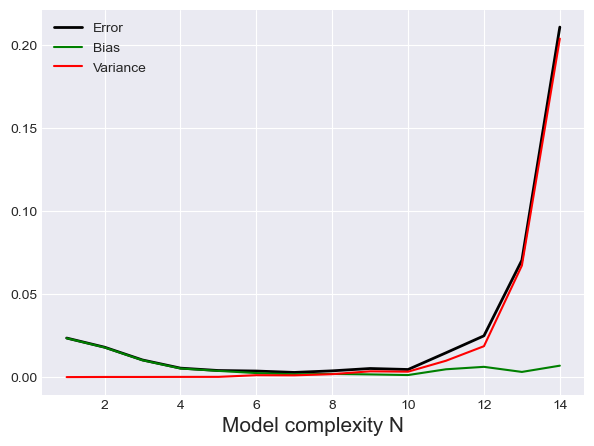

In [5]:
# Error, bias, variance plotted as function of complexity

error_ols, bias_ols, variance_ols = biasvar_linreg(solver='ols')

order = np.array([b+1 for b in range(n)])

fig = plt.figure(figsize = (7, 5)) 
plt.plot(order, error_ols-sigma**2, color="k", label='Error', linewidth = 2)
plt.plot(order, bias_ols-sigma**2, color="g", label='Bias', linewidth = 1.5)
plt.plot(order, variance_ols, color="r", label='Variance', linewidth = 1.5)
plt.xlabel('Model complexity N', fontsize = 15)
# plt.ylim(-0.005, 0.08)
plt.legend(); plt.grid(1); plt.show()

_Figure 1. Bias-variance trade off analysis of a 20 × 20 Franke function where OLS regression has been applied with a bootstrap resampling of n = 100. The bias, variance and MSE scores are calculated from the test values of polynomial models up to a degree of d = 14._

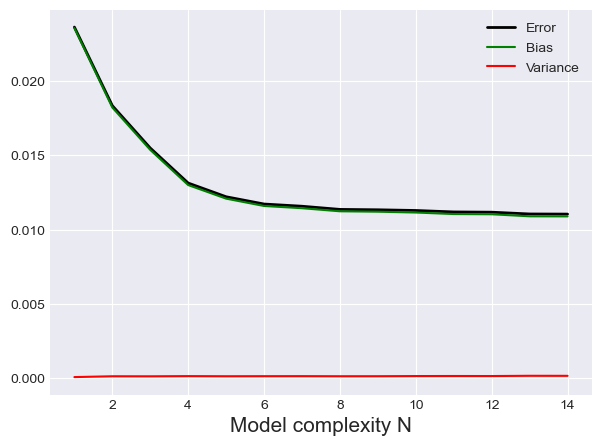

In [16]:
error_ridge, bias_ridge, variance_ridge = biasvar_linreg(solver='ridge')
order = np.array([b+1 for b in range(n)])

fig = plt.figure(figsize = (7, 5)) 
plt.plot(order, error_ridge-sigma**2, color="k", label='Error', linewidth = 2)
plt.plot(order, bias_ridge-sigma**2, color="g", label='Bias', linewidth = 1.5)
plt.plot(order, variance_ridge, color="r", label='Variance', linewidth = 1.5)
plt.xlabel('Model complexity N', fontsize = 15)
# plt.ylim(-0.005, 0.08)
plt.legend(); plt.grid(1); plt.show()

_Figure 2. Bias-variance trade off analysis of a 20 × 20 Franke function where Rodge regression has been applied with a bootstrap resampling of n = 100. The bias, variance and MSE scores are calculated from the test values of polynomial models up to a degree of d = 14._

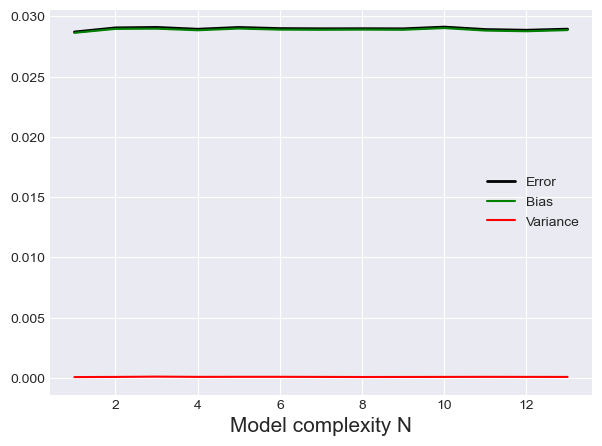

In [6]:
error_lasso, bias_lasso, variance_lasso = biasvar_linreg(solver='lasso')
order = np.array([b+1 for b in range(n)])

fig = plt.figure(figsize = (7, 5)) 
plt.plot(order, error_lasso-sigma**2, color="k", label='Error', linewidth = 2)
plt.plot(order, bias_lasso-sigma**2, color="g", label='Bias', linewidth = 1.5)
plt.plot(order, variance_lasso, color="r", label='Variance', linewidth = 1.5)
plt.xlabel('Model complexity N', fontsize = 15)
# plt.ylim(-0.005, 0.08)
plt.legend(); plt.grid(1); plt.show()

We begin by studying the methods used for linear regression, where we use the polynomial degree as a measure for the complexity. Figure~\ref{fig: OLS} shows the bias-variance as a function of the complexity of the model when using the OLS method, while figure~\ref{fig: ridge} shows the same using Ridge regression. Linear regression models such as these generally have a high bias and a low variance, which is in accordance with what we observe from both figures. 
For the OLS method, the bias decreases with higher complexity, while the variance increases. The same is true for the  bias using the Ridge method, however the variance remains almost constant here. 
The ridge model is better at handling the error caused by the variance. This is sensible, as the $\lambda$ parameter is introduced to deal with overfitting, ensuring that the model does not blow up for higher complexity. 
% The lasso model is not as sensitive to low values for $\lambda$, as it uses a hyperparameter $\lambda$ and not $\lambda^2$, like the Ridge method does. Therefore, we should see less overfitting for this model. 


## Deep learning (FFNN and/or recurrent neural networks)

Next we test the FFNN using the `MLPRegressor` from `sklearn.neural_network`, which implements a multi-layer perceptron (MLP) that trains using backpropagation with no activation function in the ouput layer, which can also be seen as using the identity function as an activation function. Therefore, it uses the square error as the loss function, and the output is a set of continuous values~\cite{https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression}. 

The complexity is tested against the number of hidden layers and number of neutons in a layer. XXX 

In [13]:
n_boostraps = 75
hidden_layers = 15

error = np.zeros(hidden_layers)
bias = np.zeros(hidden_layers)
variance = np.zeros(hidden_layers)


for n in trange(hidden_layers):
    X_ = create_X(x_, y_, n+1)
    X_train_, X_test_, z_train_, z_test_ = train_test_split(X_, z.ravel(), test_size=0.2, random_state = 40)
    z_pred = np.empty((z_test_.shape[0], n_boostraps))
    for i in range(n_boostraps):
        X_, z_ = resample(X_train_, z_train_)

        activation = 'relu' # linear, relu 

        model = MLPRegressor(hidden_layer_sizes=(n+1, n+1, n+1), activation=activation, solver ='lbfgs',alpha=10, learning_rate_init=1.e-5, max_iter=1000) # Different result 
        model.fit(X_, z_)
        z_pred[:, i] = model.predict(X_test_)
        
        # z_pred[:, i] = model.fit(X_, z_).predict(X_test_).ravel() 

    error[n] = np.mean( np.mean((z_test_.reshape(-1, 1) - z_pred)**2, axis=1, keepdims=True) )
    bias[n] = np.mean( (z_test_.reshape(-1, 1) - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[n] = np.mean( np.var(z_pred, axis=1, keepdims=True) )


100%|██████████| 15/15 [08:03<00:00, 32.23s/it]


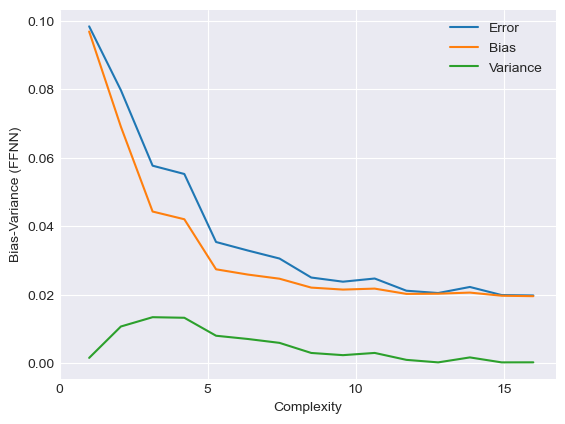

In [16]:
hidden_neurons = np.linspace(1, hidden_layers+1, hidden_layers)

plt.plot(hidden_neurons, error-sigma**2, label = 'Error')
plt.plot(hidden_neurons, bias-sigma**2, label = 'Bias')
plt.plot(hidden_neurons, variance, label = 'Variance')
plt.ylabel('Bias-Variance (FFNN)')
plt.xlabel('Complexity') # Number of neurons per layer
plt.xticks(np.arange(0, hidden_layers+1, step=5)) 
plt.legend()
plt.show()

More complex models, such as random forest, generally have a lower bias but higher variance. While the bias remains higher than the variance for this model, it is still lower than for the linear regression models. 


## Ensemble methods (Decision trees, bagging, random forests and boosting)




Tree - Complexity is tree depth or number of leaves

In [28]:
n_boostraps = 50
max_depth = 10

error = np.zeros(max_depth)
bias = np.zeros(max_depth)
variance = np.zeros(max_depth)


for n in trange(max_depth):
    X_ = create_X(x_, y_, n+1)
    X_train_, X_test_, z_train_, z_test_ = train_test_split(X_, z.ravel(), test_size=0.2, random_state = 40)
    z_pred = np.empty((z_test_.shape[0], n_boostraps))
    for i in range(n_boostraps):
        X_, z_ = resample(X_train_, z_train_)

        activation = 'relu' # linear, relu 

        # model = RandomForestRegressor(n_estimators=n+1, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1)
        model = RandomForestRegressor(max_depth=n+1)
        # Random_Forest_model = RandomForestRegressor(min_samples_leaf=n+1)
        # model = BaggingClassifier(n_estimators=n+1)
        # model = GradientBoostingRegressor(n_estimators=n+1)
        
        model.fit(X_, z_)
        z_pred[:, i] = model.predict(X_test_)
        
        # z_pred[:, i] = model.fit(X_, z_).predict(X_test_).ravel() 

    error[n] = np.mean( np.mean((z_test_.reshape(-1, 1) - z_pred)**2, axis=1, keepdims=True) )
    bias[n] = np.mean( (z_test_.reshape(-1, 1) - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[n] = np.mean( np.var(z_pred, axis=1, keepdims=True) )


100%|██████████| 10/10 [06:47<00:00, 40.77s/it]


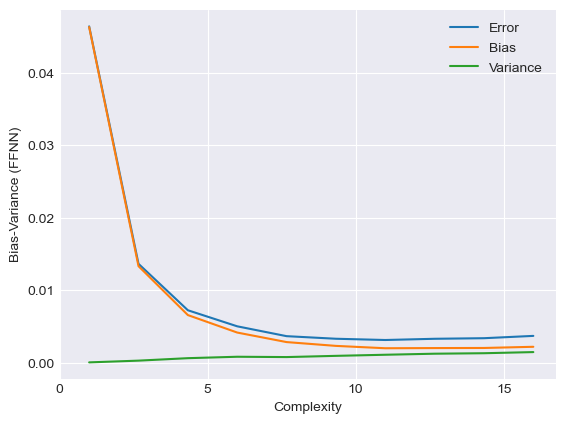

In [30]:
hidden_neurons = np.linspace(1, hidden_layers+1, max_depth)

plt.plot(hidden_neurons, error-sigma**2, label = 'Error')
plt.plot(hidden_neurons, bias-sigma**2, label = 'Bias')
plt.plot(hidden_neurons, variance, label = 'Variance')
plt.ylabel('Bias-Variance (FFNN)')
plt.xlabel('Complexity') # Number of neurons per layer
plt.xticks(np.arange(0, hidden_layers+1, step=5)) 
plt.legend()
plt.show()

More complex models, such as random forest, generally have a lower bias but higher variance. This is in accordance with the random forest, but i need to read more about it to know if im plotting against the correct things here. 



If the number of features is relatively large (high dimensional) and the number of instances is relatively low, the tree might overfit the data

The **plain** decision trees suffer from high variance. This means that if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different. In contrast, a procedure with low variance will yield similar results if applied repeatedly to distinct data sets; linear regression tends to have low variance, if the ratio of n to p

Simple tree: 0.4809960222772678


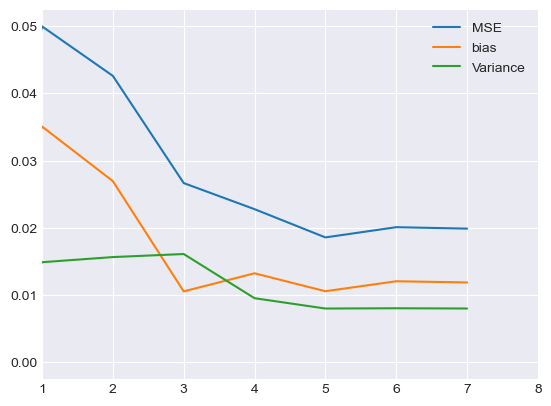

In [3]:


import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.tree import DecisionTreeRegressor

n = 100
n_boostraps = 100
maxdepth = 8

# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)
error = np.zeros(maxdepth)
bias = np.zeros(maxdepth)
variance = np.zeros(maxdepth)
polydegree = np.zeros(maxdepth)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# we produce a simple tree first as benchmark
simpletree = DecisionTreeRegressor(max_depth=3) 
simpletree.fit(X_train_scaled, y_train)
simpleprediction = simpletree.predict(X_test_scaled)
for degree in range(1,maxdepth):
    model = DecisionTreeRegressor(max_depth=degree) 
    y_pred = np.empty((y_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(X_train_scaled, y_train)
        model.fit(x_, y_)
        y_pred[:, i] = model.predict(X_test_scaled)#.ravel()

    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    # print('Polynomial degree:', degree)
    # print('Error:', error[degree])
    # print('Bias^2:', bias[degree])
    # print('Var:', variance[degree])
    # print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))
 
mse_simpletree= np.mean( np.mean((y_test - simpleprediction)**2))
print("Simple tree:",mse_simpletree)
plt.xlim(1,maxdepth)
plt.plot(polydegree, error, label='MSE')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
plt.show()


/home/semya/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/semya/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/semya/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/semya/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

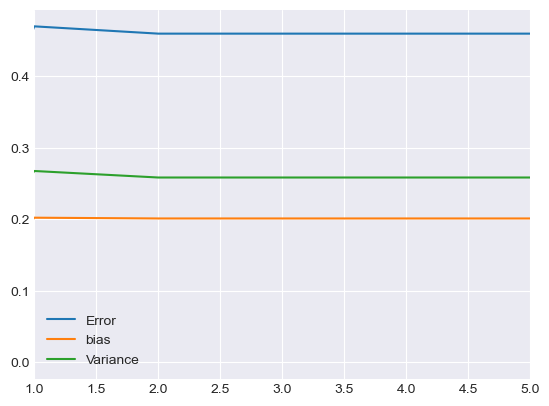

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
# import scikitplot as skplt
from sklearn.metrics import mean_squared_error

n = 100
maxdegree = 6

# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for degree in range(1,maxdegree):
    model = GradientBoostingRegressor(max_depth=degree, n_estimators=100, learning_rate=1.0)  
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((y_test - y_pred)**2) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred))**2 )
    variance[degree] = np.mean( np.var(y_pred) )
    # print('Max depth:', degree)
    # print('Error:', error[degree])
    # print('Bias^2:', bias[degree])
    # print('Var:', variance[degree])
    # print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

plt.xlim(1,maxdegree-1)
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
# save_fig("gdregression")
plt.show()

ModuleNotFoundError: No module named 'xgboost'